In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

## Getting the Training and Testing Datasets

In [2]:
folders = {
    'bending1': 7,
    'bending2': 6,
    'cycling': 15,
    'lying' : 15,
    'sitting': 15,
    'standing': 15,
    'walking': 15  
}
testing_paths = []
training_paths = []
ordered_paths = []
for activity, _max in folders.items():
    for i in range(1, _max + 1):
        ordered_paths.append((f'../data/{activity}/dataset{i}.csv', activity))
        if i <= 2:
            testing_paths.append(f'../data/{activity}/dataset{i}.csv')    
        elif i == 3 and activity not in ['bending1', 'bending2']:
            testing_paths.append(f'../data/{activity}/dataset{i}.csv')
        else:
            training_paths.append(f'../data/{activity}/dataset{i}.csv')
            
columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
testing_dfs = [pd.read_csv(path, skiprows = 4).iloc[:, 1:] for path in testing_paths]
training_dfs = []
for path in training_paths:
    if path == f'../data/bending2/dataset4.csv':
        df = pd.read_csv(f'../data/bending2/dataset4.csv', skiprows = 5, delimiter = ' ', index_col = False, names = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']).iloc[:, 1:]
    else:
        df = pd.read_csv(path, skiprows=4).iloc[:, 1:]
    training_dfs.append(df)

print(f"Number of instances {len(testing_dfs) + len(training_dfs)}")
print(f"Number of testing instances {len(testing_dfs)}")
print(f"Number of training instances {len(training_dfs)}")

Number of instances 88
Number of testing instances 19
Number of training instances 69


# 2. Time Series Classification Part 2: Binary and Multiclass Classification

## (a) Binary Classification Using Logistic Regression

### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).4

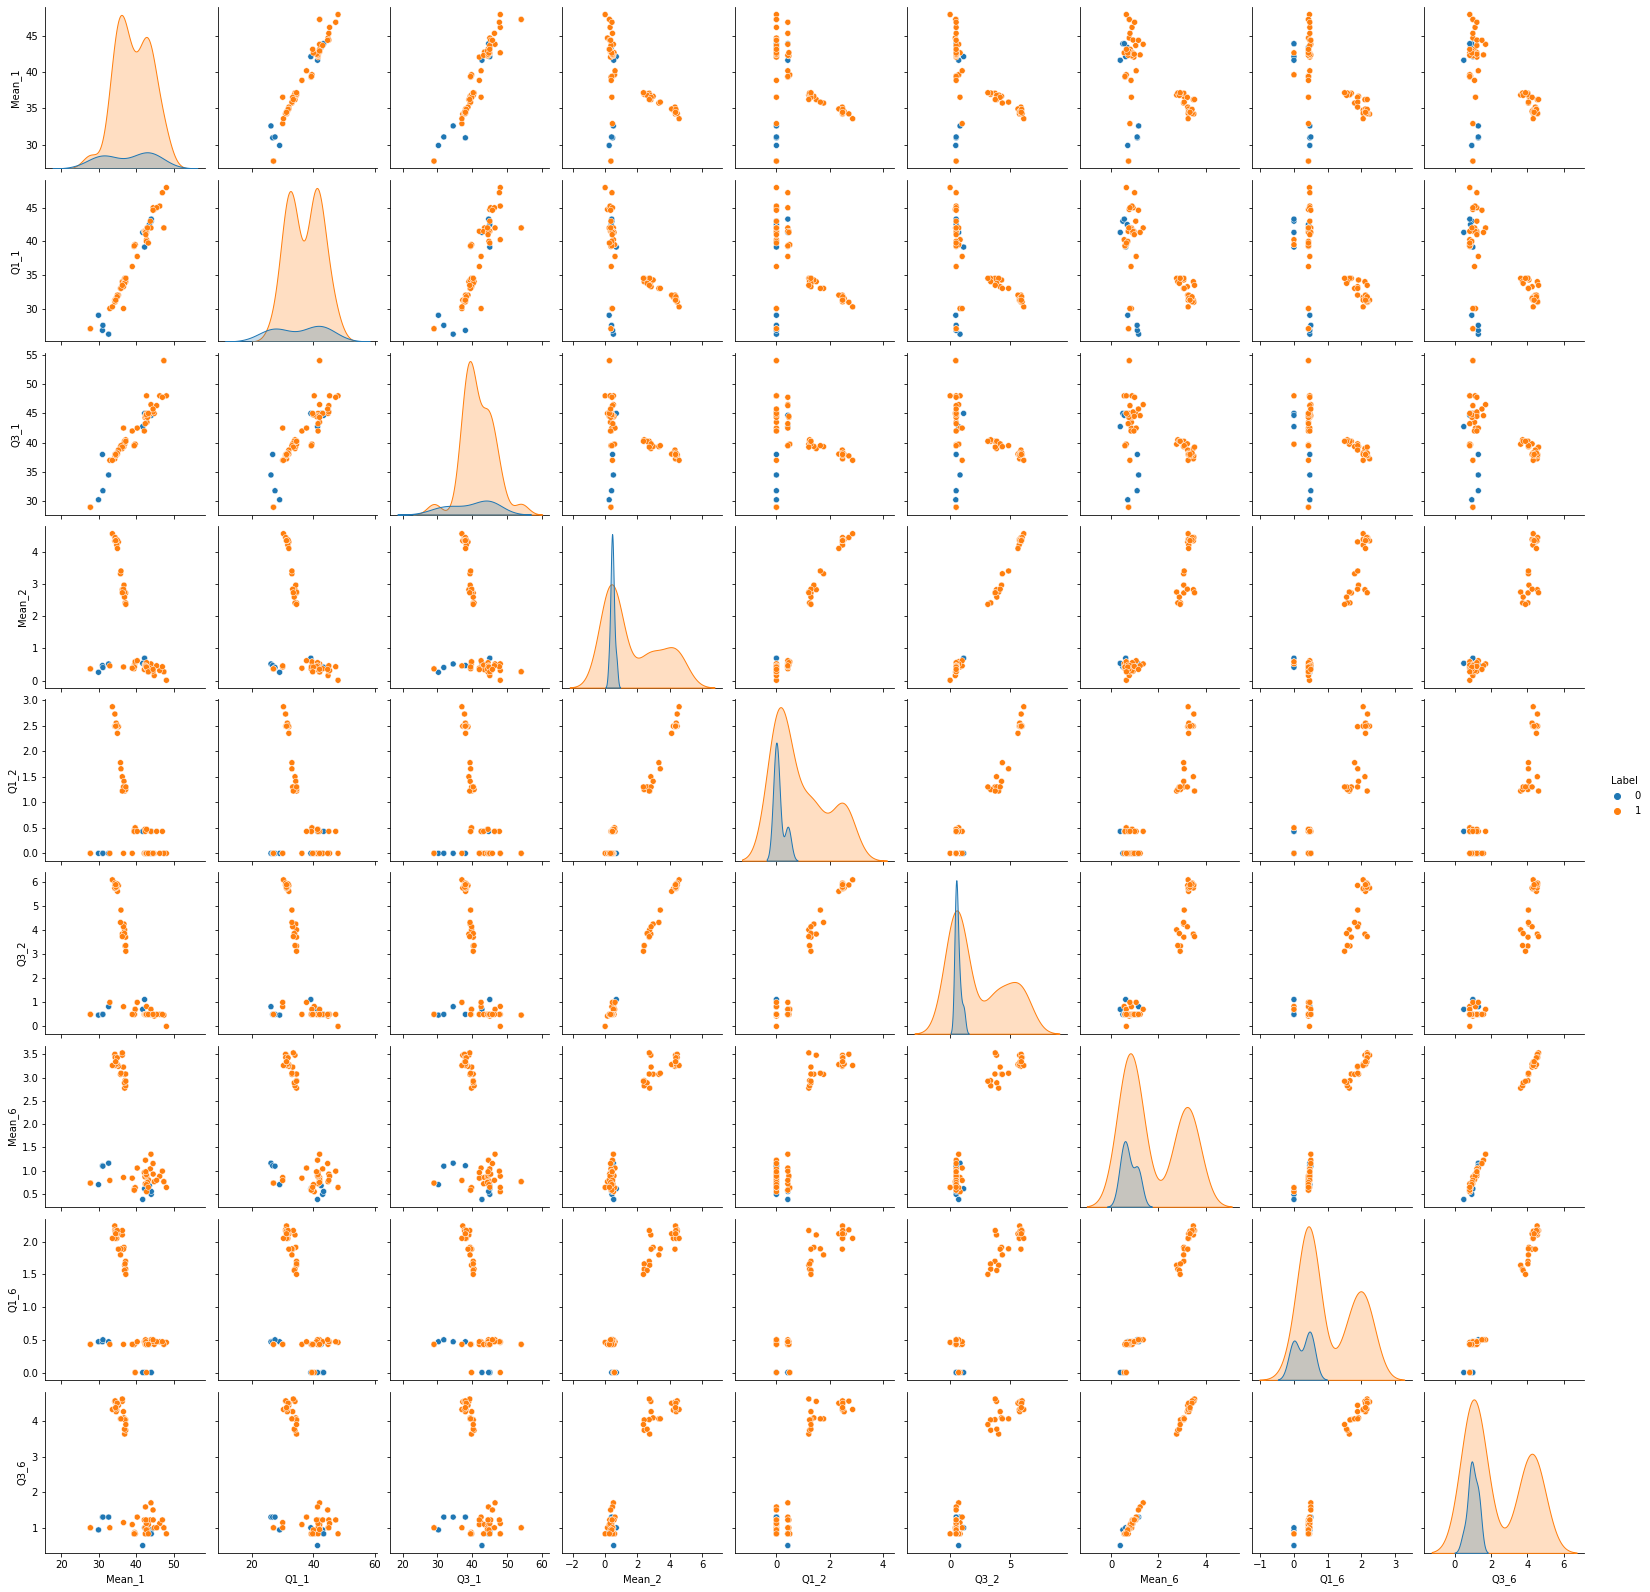

In [3]:
cols = ['Mean_1', 'Q1_1', 'Q3_1', 'Mean_2', 'Q1_2', 'Q3_2', 'Mean_6', 'Q1_6', 'Q3_6', 'Label']
column_nums = [1,2,6] # take col - 1 for proper indexing
rows = []
for df, path in zip(training_dfs, training_paths):
    label = path.split('/')[2]
    if 'bending' in label:
        label = 0
    else:
        label = 1
    row = []
    for val in column_nums:
        row.append(df[df.columns[val-1]].astype(float).mean())
        row.append(df[df.columns[val-1]].astype(float).quantile(0.25))
        row.append(df[df.columns[val-1]].astype(float).quantile(0.75))
    row.append(label)
    rows.append(row)
scatter_df = pd.DataFrame(rows, columns = cols)
sns.pairplot(scatter_df, vars = scatter_df.columns[:-1], hue="Label")
plt.show()

### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

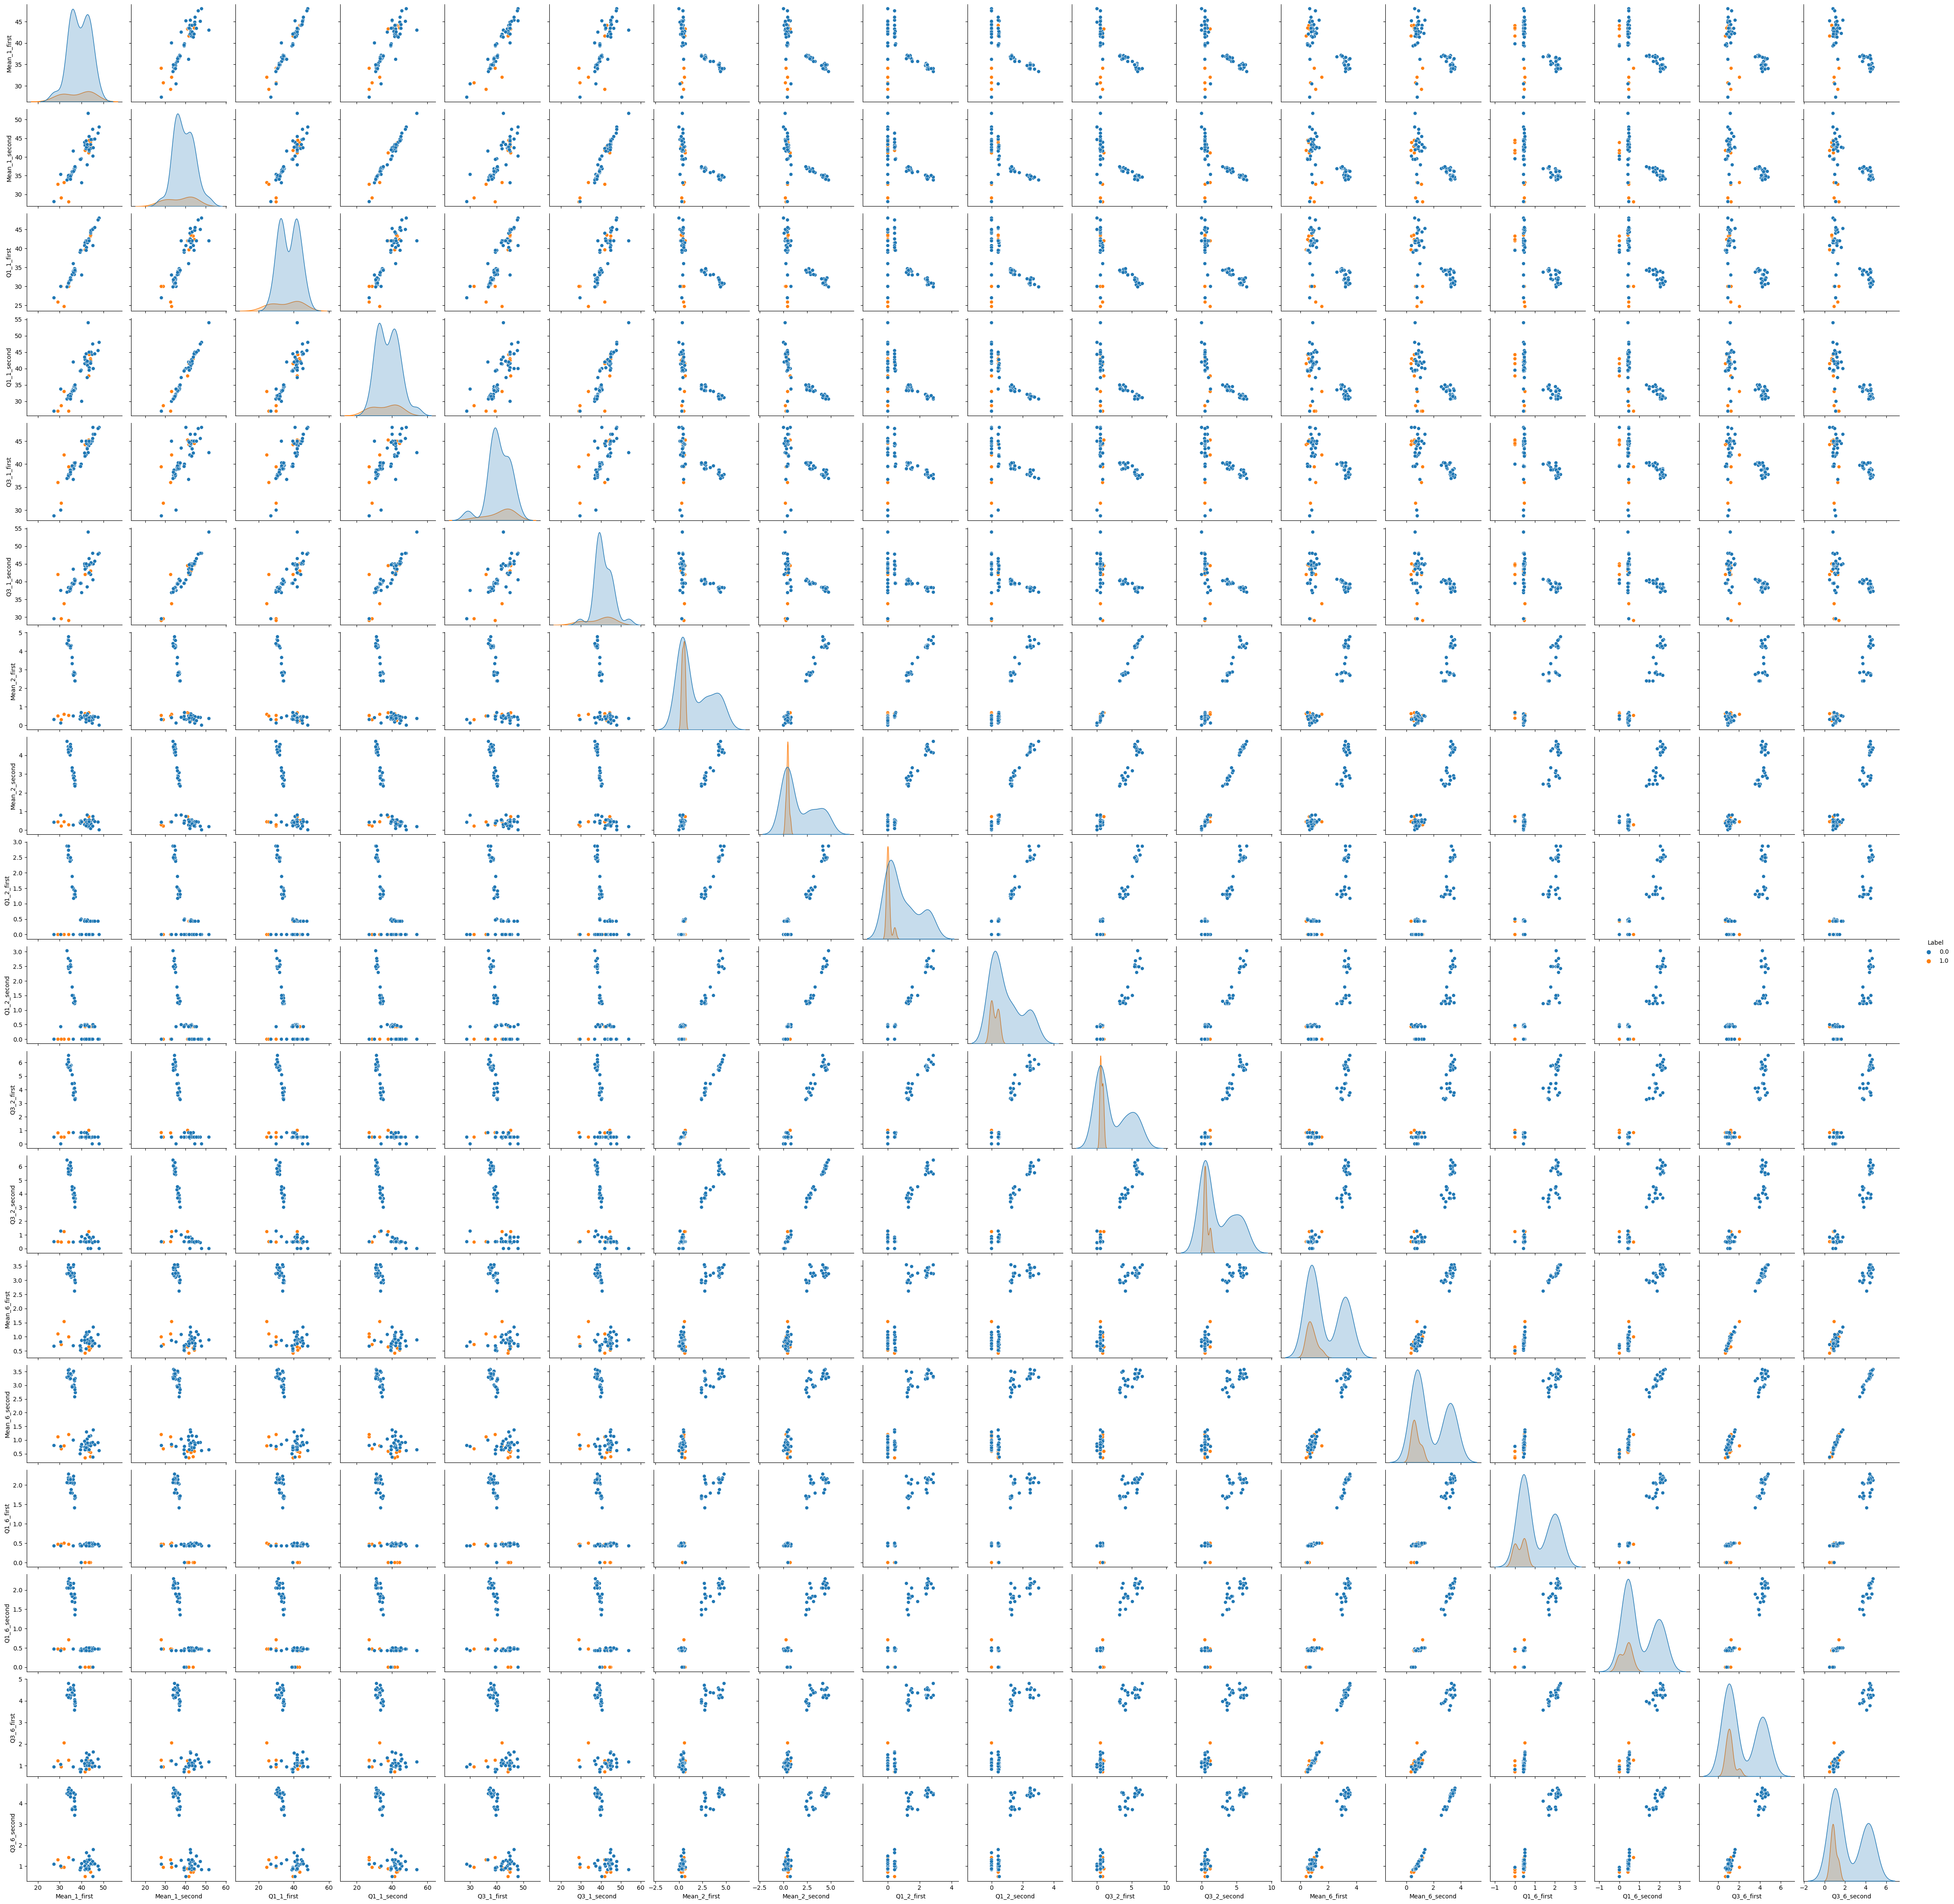

In [16]:
cols = ['Mean_1_first', 'Mean_1_second', 'Q1_1_first', 'Q1_1_second', 'Q3_1_first', 'Q3_1_second', 'Mean_2_first', 'Mean_2_second', 'Q1_2_first', 'Q1_2_second', 'Q3_2_first', 'Q3_2_second', 'Mean_6_first', 'Mean_6_second', 'Q1_6_first', 'Q1_6_second', 'Q3_6_first', 'Q3_6_second', 'Label']
column_nums = [1,2,6] # take col - 1 for proper indexing
rows = []
for df, path in zip(training_dfs, training_paths):
    label = path.split('/')[2]
    half = len(df) // 2
    if 'bending' in label:
        label = 1
    else:
        label = 0
    row = []
    for val in column_nums:
        current = np.reshape(df.iloc[:,val-1].astype(float).values, (-1,1))
        row.append(current[:half].mean())
        row.append(current[half:].mean())
        row.append(np.percentile(current[:half], 25, method = 'midpoint'))
        row.append(np.percentile(current[half:], 25, method = 'midpoint'))
        row.append(np.percentile(current[:half], 75, method = 'midpoint'))
        row.append(np.percentile(current[half:], 75, method = 'midpoint'))
    row.append(float(label))
    rows.append(row)
    
# scatter_df = pd.DataFrame(rows, columns = cols)
# print(scatter_df.columns)
# for i in range(len(scatter_df.columns)-1):
#     for j in range(len(scatter_df.columns)-1):
#         sns.scatterplot(x= scatter_df[scatter_df.columns[i]], y= scatter_df[scatter_df.columns[j]])
#         plt.show()
scatter_df = pd.DataFrame(rows, columns = cols)
sns.pairplot(scatter_df, vars = scatter_df.columns[:-1], hue="Label")
plt.show()
